# CNN for Joint and bolt classification 

## library requirments 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2 as cv

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Data split and batch selection

In [3]:
batch_size = 16
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Edge',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Edge',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 282 files belonging to 6 classes.
Using 226 files for training.
Found 282 files belonging to 6 classes.
Using 56 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Eye-bolt', 'L-joint', 'T-joint', 'U-bolt', 'butt-joint', 'wing-bolt']


## Image processing and Normalization

In [6]:
import os
import cv2
import imghdr
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/drive/MyDrive/data'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  T joints
processing class directory  Butt joint
processing class directory  I joint
processing class directory  U bolt
processing class directory  Eye bolt
processing class directory  wing bolt
 no improper image files were found


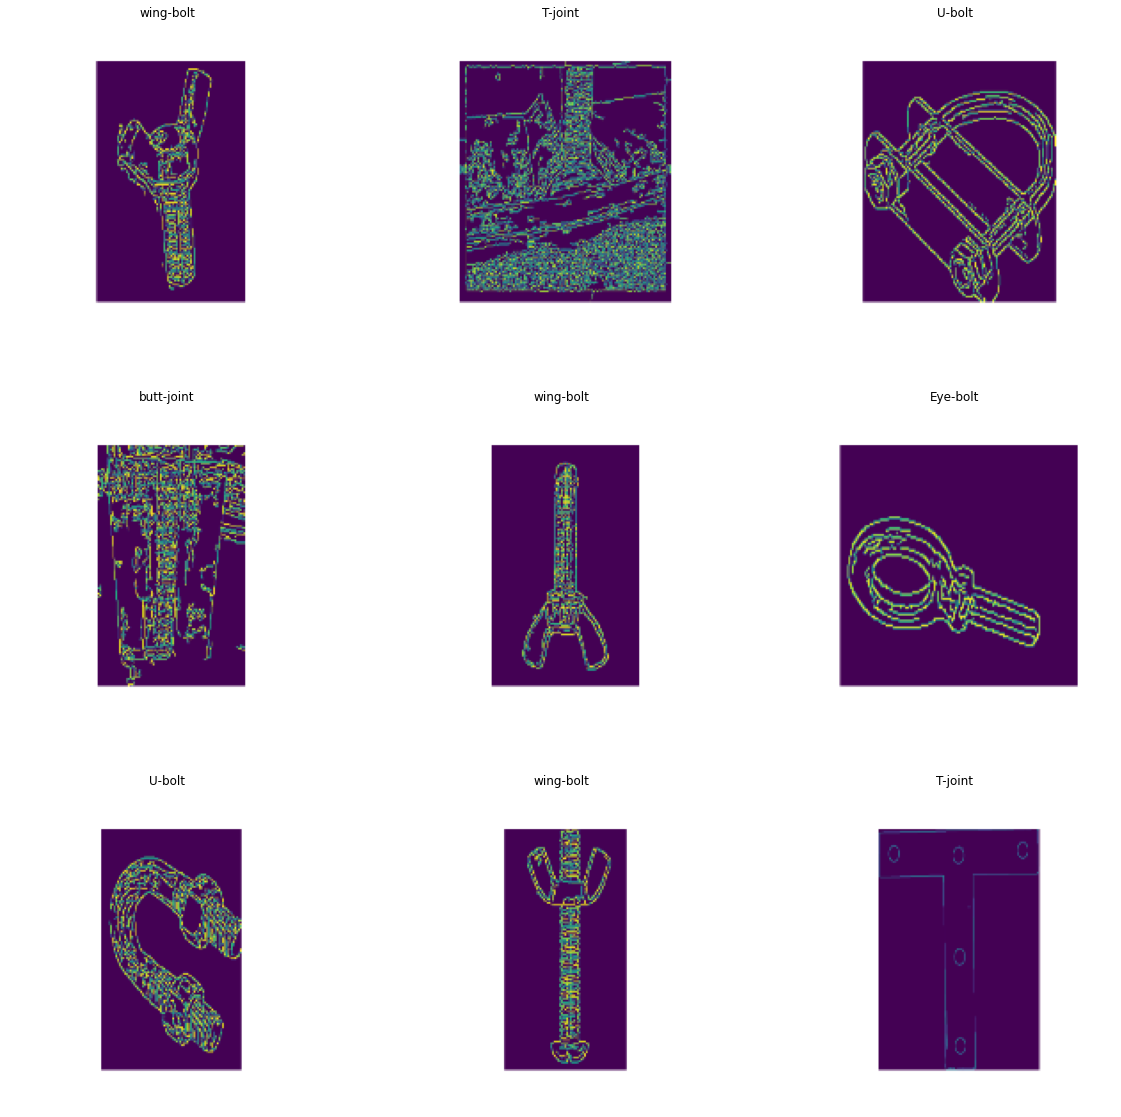

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 180, 180, 3)
(16,)


In [9]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.003921569 1.0


## Model development and sving

In [10]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 8)         1

In [13]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
15/15 [==============================] - 19s 1s/step - loss: 1.7783 - accuracy: 0.2257 - val_loss: 1.8838 - val_accuracy: 0.1607
Epoch 2/15
15/15 [==============================] - 3s 146ms/step - loss: 1.6832 - accuracy: 0.2655 - val_loss: 1.7283 - val_accuracy: 0.2500
Epoch 3/15
15/15 [==============================] - 3s 147ms/step - loss: 1.5563 - accuracy: 0.4558 - val_loss: 1.7151 - val_accuracy: 0.2857
Epoch 4/15
15/15 [==============================] - 3s 148ms/step - loss: 1.3803 - accuracy: 0.4823 - val_loss: 1.6364 - val_accuracy: 0.3750
Epoch 5/15
15/15 [==============================] - 3s 148ms/step - loss: 1.3055 - accuracy: 0.5265 - val_loss: 1.4614 - val_accuracy: 0.3393
Epoch 6/15
15/15 [==============================] - 3s 149ms/step - loss: 1.1395 - accuracy: 0.5929 - val_loss: 1.3161 - val_accuracy: 0.3750
Epoch 7/15
15/15 [==============================] - 3s 149ms/step - loss: 0.9594 - accuracy: 0.6549 - val_loss: 1.1940 - val_accuracy: 0.4821
Epoch 8/

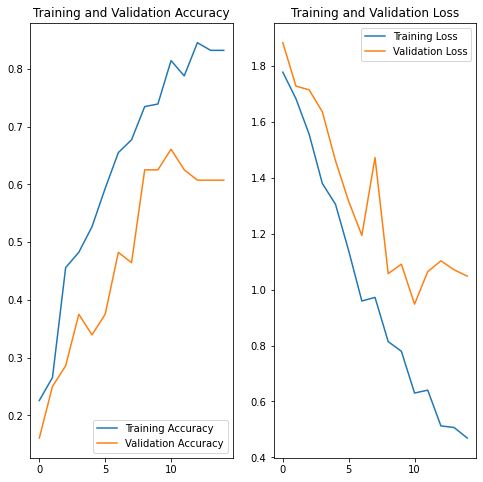

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/data.h5')

## Testing

In [16]:
model=load_model('/content/drive/MyDrive/data.h5')

In [19]:
img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/Edge/L-joint/Screenshot 2022-10-19 120917.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 15ms/step
This image most likely belongs to L-joint with a 82.65 percent confidence.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
